In [3]:
import os
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #,1,2,3"

In [4]:
from run_experiment_clas import *
run_experiment('configs.json')

Setting up Experiment folder ...
2021-04-24/classification_test_2021-04-24_18:09:52
Partitionin gdataset IDs ...
Setting up data Generators ...
Getting callbacks ...
Setting up model ...
Training ...
Epoch 1/50
33/33 [==============================] - 6s 185ms/step - loss: 0.0842 - val_loss: 1.1728e-07
Epoch 2/50
19/33 [================>.............] - ETA: 2s - loss: 1.1686e-07

KeyboardInterrupt: 

## TODO:
* run experiment
* load model and do some preditions - evaluate on trin and val datasets
* if everything is good then try with larger grid
* or try with nearest neighbour
* think about the limitations of one hot encoding - realistically how many categories can you accopodate for? If you use SpareCrossEntropy does your model output an integer or a vector of length=num_classes?

# Load data

In [3]:
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_full/"

In [4]:
data_size = 370
images = np.empty((data_size, 256,512, 3), dtype=np.int16)
labels = np.empty((data_size, 256,512), dtype=np.float32)
masks = np.empty((data_size, 256,512), dtype=np.int16)

for ind in tqdm(range(data_size)):
    coord_npz = f"{ind+1:04}_rendered.png_config.npz"
    npz_data = np.load(data_dir + coord_npz)
    
    images[ind] = npz_data['image_colors']
    
    coord_class_file_name = f"/{ind+1:04}_simple_region_class.npy"
    labels[ind] = np.load(data_dir + coord_class_file_name)
    
    mask_file_name = f"/{ind+1:04}_mask.npy"
    masks[ind] = np.load(data_dir + mask_file_name)

100%|██████████| 370/370 [00:01<00:00, 344.72it/s]


In [5]:
print(labels.shape)
labels = (np.arange(labels.max()+1) == labels[...,None]).astype(int)
print(labels.shape)

(370, 256, 512)
(370, 256, 512, 8)


# Load model

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
def masked_X_entropyCE(y_true, y_pred):
    " masked CrossEntropy - used for classification of regions "

    mask = y_true[:,:,:,-1]
    y_true = y_true[:,:,:,:8]

    nested_masks = [mask for _ in range(8)]
    mask_expanded = tf.stack(nested_masks, axis=-1)

    y_pred = tf.math.multiply(y_pred, mask_expanded)
    y_true = tf.math.multiply(y_true, mask_expanded)

    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss

In [6]:
model_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/experiments/2021-04-24/classification_test_2021-04-24_13:12:01/model_checkpoint"
unet_model = keras.models.load_model(model_dir, compile=False)
unet_model.compile(optimizer=keras.optimizers.Adam(1e-6), loss=masked_X_entropyCE)

In [7]:
def crop_image(image, coords, mask, orig_dim, start_row=None, start_col=None):
        
    # pick the start cordinates of croped images
    if start_row == None:
        start_row = np.random.randint(0, high=orig_dim[0]-224)
    if start_col == None:
        start_col = np.random.randint(0, high=orig_dim[1])

    # get all pixels that span 224 to the right and down from start pixels
    # if a croped image runs across right image border, then use concatenate to combine pixels of croped image
    if start_col + 224 > 512:
        dif = start_col + 224 - 512
        wraped_image = image[start_row:start_row+224, :dif,:]
        wraped_coords = coords[start_row:start_row+224, :dif,:]
        wraped_mask = mask[start_row:start_row+224, :dif]
        
        croped_image = np.concatenate(
            (image[start_row:start_row+224, start_col:start_col+224,:], wraped_image), axis=1)
        croped_coords = np.concatenate(
            (coords[start_row:start_row+224, start_col:start_col+224,:], wraped_coords), axis=1)
        croped_mask = np.concatenate(
            (mask[start_row:start_row+224, start_col:start_col+224], wraped_mask), axis=1)

    else:
        croped_image = image[start_row:start_row+224, start_col:start_col+224,:]
        croped_coords = coords[start_row:start_row+224, start_col:start_col+224,:]
        croped_mask = mask[start_row:start_row+224, start_col:start_col+224]

    return croped_image, croped_coords, croped_mask

In [8]:
ind = 1
image_croped, labels_croped, mask_croped = crop_image(images[ind], labels[ind], masks[ind], (256,512))

image_croped = np.expand_dims(image_croped, axis=0)
pred = unet_model.predict(image_croped)

In [9]:
pred_categorical = np.argmax(pred, axis=-1)
labels_croped_categorical = np.argmax(labels_croped, axis=-1)
pred_categorical.shape

(1, 224, 224)

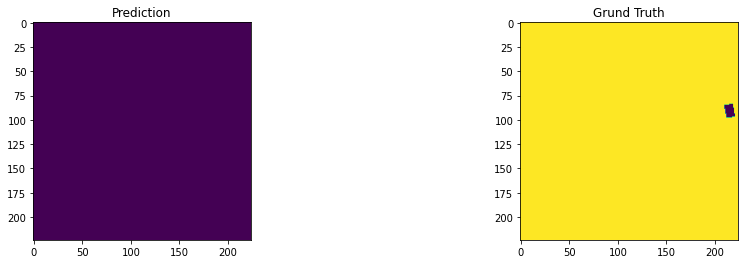

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.imshow(pred_categorical[0])
ax1.set_title("Prediction")

ax2.imshow(labels_croped_categorical)
ax2.set_title("Grund Truth")
plt.show()

In [11]:
np.unique(pred_categorical)

array([0])

In [12]:
np.unique(labels_croped_categorical)

array([5, 7])

In [13]:
pred_categorical

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [14]:
labels_croped_categorical

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]])

In [15]:
pred

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [68]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, batch_size=8, dim=(256,512), n_channels=3, shuffle=True, num_crops=4):

        self.npz_file_IDs = npz_file_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.int16)
        labels = np.empty((self.batch_size, *self.dim), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.dim), dtype=np.int16)

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)
            
            images[i] = npz_data['image_colors'].astype(int)
            # labels[i] = npz_data['points_3d_world']
            
            data_dir = "/".join(ID.split('/')[:-1])
            ind = ID.split('/')[-1].split('_')[0]
            coord_class_file_name = f"/{ind}_simple_region_class.npy"
            labels[i] = np.load(data_dir + coord_class_file_name)

            mask_file_name = f"/{ind}_mask.npy"
            masks[i] = np.load(data_dir + mask_file_name)

        return images, labels, masks
            
            
    def load_and_downsample(self, npz_file_ID_temp):
        """ We choose to downsample to 256x512 and then crop 224x224 images. Downsampling to
        256x512 has proven to work well in practice, although we ourselves haven't tested that statement."""
        images = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.int16)
        labels = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)

            images[i,:,:,:] = cv2.resize(npz_data['image_colors'], self.dim[::-1], interpolation = cv2.INTER_CUBIC)
            labels[i,:,:,:] = cv2.resize(np.array(npz_data['points_3d_world'], dtype=np.float32), self.dim[::-1], interpolation = cv2.INTER_NEAREST)

        return images, labels

    
    def get_image_crops(self, images, labels, masks):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        image_crops = np.zeros((self.batch_size, 224, 224, self.n_channels), dtype=np.int16)
        label_crops = np.zeros((self.batch_size, 224, 224), dtype=np.float32)
        mask_crops = np.zeros((self.batch_size, 224, 224), dtype=np.float32)

        # pick the start cordinates of croped images
        start_row = np.random.randint(0, high=self.dim[0]-224, size=self.batch_size)
        start_col = np.random.randint(0, high=self.dim[1], size=self.batch_size)

        # get all pixels that span 224 to the right and down from start pixels
        for ind in range(self.batch_size):

            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_image = images[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                wraped_label = labels[ind, start_row[ind]:start_row[ind]+224, :dif]
                wraped_mask = masks[ind, start_row[ind]:start_row[ind]+224, :dif]
                
                image_crops[ind] = np.concatenate(
                    (images[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_image), axis=1)
                label_crops[ind] = np.concatenate(
                    (labels[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224], 
                        wraped_label), axis=1)
                mask_crops[ind] = np.concatenate(
                    (masks[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224], 
                        wraped_mask), axis=1)
            else:
                image_crops[ind] = images[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]
                label_crops[ind] = labels[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224]
                mask_crops[ind] = masks[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224]


        return image_crops, label_crops, mask_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
    def get_mask(self, labels):
        sumed_coords = np.sum(labels, axis=-1)
        mask = np.where(sumed_coords == 0, 0, 1)
        dim = mask.shape
        mask = np.reshape(mask, (dim[0], dim[1], dim[2], 1) )

        return mask
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

        # load images (from a downsampled dataset)
        images, labels, masks = self.load_data(list_IDs_temp)
        
        # Get images and labels (downsampled)
        # images, labels = self.load_and_downsample(list_IDs_temp)

        # crop
        images, labels, masks = self.get_image_crops(images, labels, masks)
        masks = np.expand_dims(masks, axis=-1)
    
        # get mask
        # mask = self.get_mask(labels)

        # one-hot encode labels
        labels = (np.arange(labels.max()+1) == labels[...,None]).astype(int)

        # coccatenate to images
        labels = np.concatenate((labels, masks), axis=-1)
        
        return images, labels

In [69]:
data_partition_file = open("/home/mlmi-2020/jz522/localisation_from_image_project/experiments/2021-04-24/classification_test_2021-04-24_11:34:10/data_partition.json")
data_partition = json.load(data_partition_file)
data_partition_file.close()

generator_configs = {
        "batch_size": 10,
        "dim": (256,512),
        "n_channels": 3,
        "shuffle": True,
        "num_crops": 1,
    }

training_generator = DataGenerator(data_partition['train'], **generator_configs)


In [70]:
gen_images, gen_labels = training_generator.__getitem__(1)

In [71]:
gen_images.shape

(10, 224, 224, 3)

In [72]:
gen_mask = gen_labels[:,:,:,8]
gen_labels =  gen_labels[:,:,:,:8]

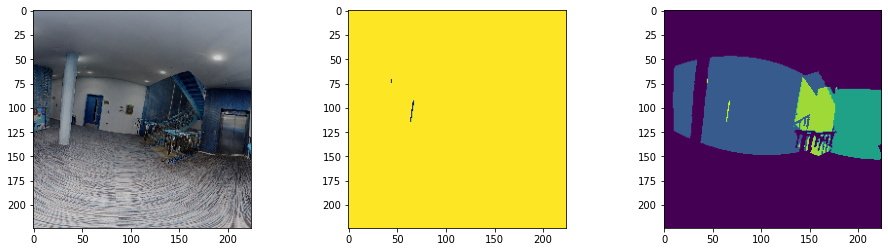

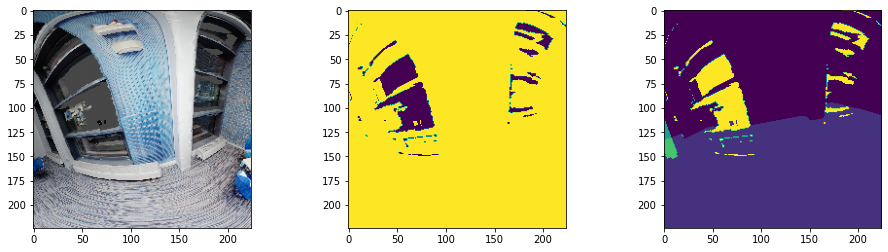

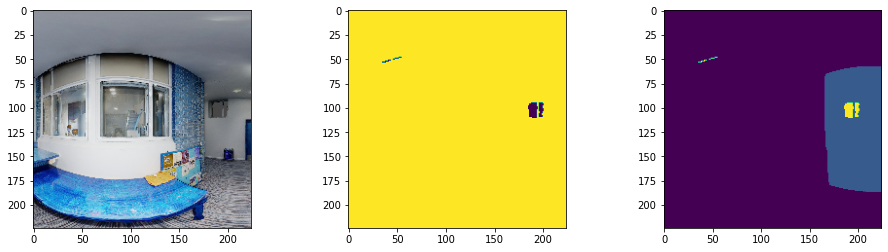

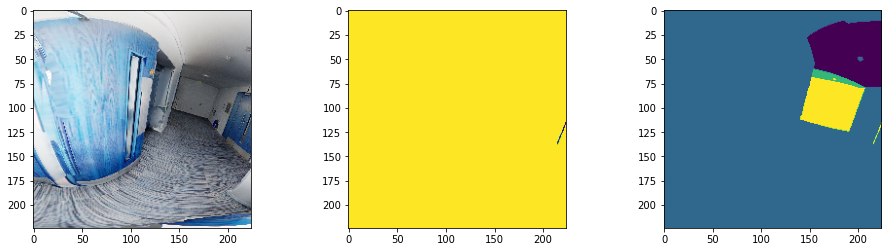

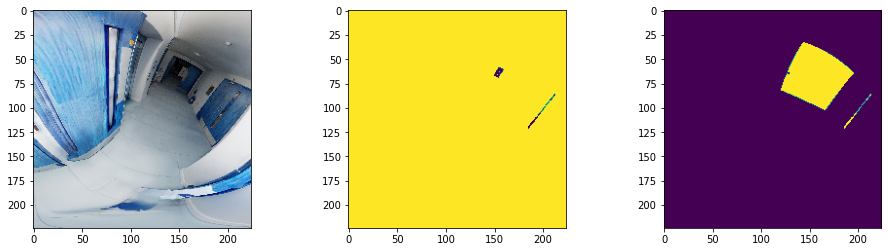

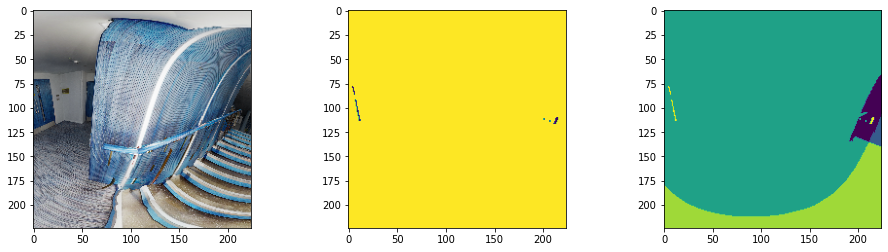

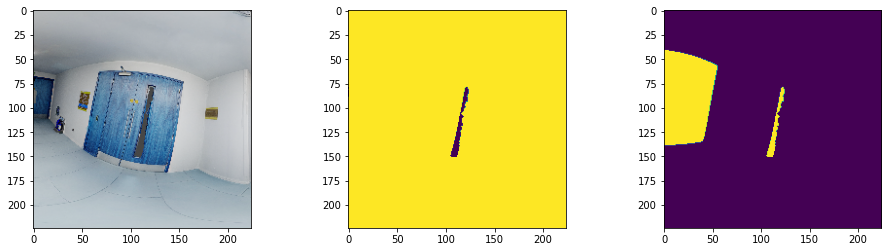

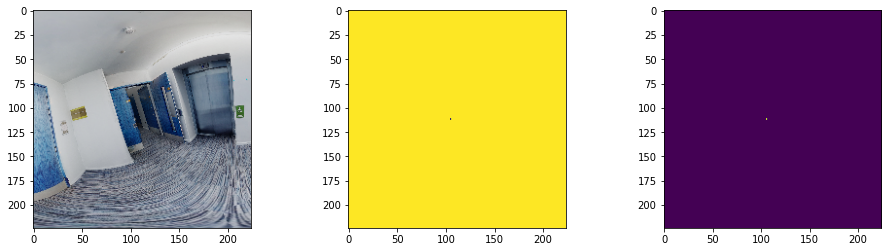

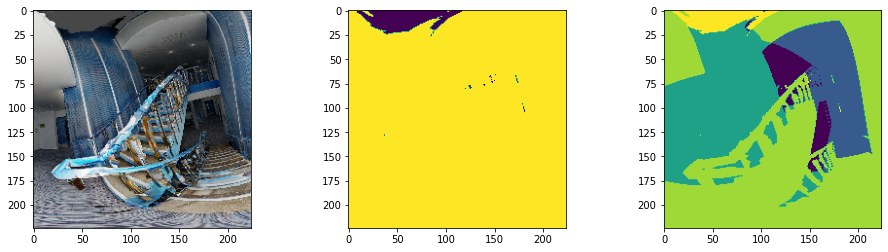

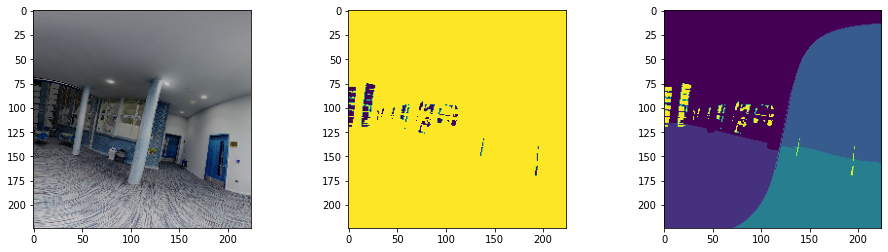

In [73]:
for i in range(10):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    
    ax1.imshow(gen_images[i])
    ax2.imshow(gen_mask[i])
    ax3.imshow(np.argmax(gen_labels[i], axis=-1))
    plt.show()